# Regression example using TF-MELT
This is a basic regression example using the models in TF-MELT.

Requires the following additional packages:
* ipykernel
* scikit-learn
* matplotlib

In [1]:
import sklearn.datasets as sdt
import matplotlib.pyplot as plt

# Create surogate data
n_samples = 1000
n_features = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 10), Shape of y: (1000, 3)


In [2]:
from tfmelt.utils.preprocessing import get_normalizers
from sklearn.model_selection import train_test_split

# Get the normalizers using the tfmelt library
x_normalizer, y_normalizer = get_normalizers(norm_type="standard", n_normalizers=2)

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

# Hyperparameters
Set consistent hyperparameters for all models for comparisons sake.

In [3]:
# General hyperparameters
n_epochs = 300
batch_size = 32
loss = "mse"
learn_rate = 1e-3
l1_reg = 0
l2_reg = 0
act_fun = "relu"
dropout = 0.1
input_dropout = 0.1
batch_norm = False
output_activation = "linear"

width = 8
depth = 2

# ResNet specific hyperparameters
layers_per_block = 4

## Artificial Neural Network (ANN)
Create and train an ANN using TF-MELT.

In [4]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
ann_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
)

# Compile the model
ann_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
ann_model.build(input_shape=(None, n_features))
ann_model.summary()


Model: "artificial_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 input_dropout (Dropout)     multiple                  0         
                                                                 
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 output (Dense)              multiple                  27        
                                         

In [5]:
# Train the model
history = ann_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.1915 - val_loss: 1.2929
Epoch 2/300
25/25 [==============================] - 0s 960us/step - loss: 1.0428 - val_loss: 1.1865
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 0.9141 - val_loss: 1.1067
Epoch 4/300
25/25 [==============================] - 0s 907us/step - loss: 0.8696 - val_loss: 1.0252
Epoch 5/300
25/25 [==============================] - 0s 910us/step - loss: 0.8010 - val_loss: 0.9372
Epoch 6/300
25/25 [==============================] - 0s 870us/step - loss: 0.7534 - val_loss: 0.8395
Epoch 7/300
25/25 [==============================] - 0s 818us/step - loss: 0.6932 - val_loss: 0.7370
Epoch 8/300
25/25 [==============================] - 0s 849us/step - loss: 0.6466 - val_loss: 0.6490
Epoch 9/300
25/25 [==============================] - 0s 832us/step - loss: 0.6031 - val_loss: 0.5776
Epoch 10/300
25/25 [==============================] - 0s 834us/step - loss: 0.5579 - val_loss: 

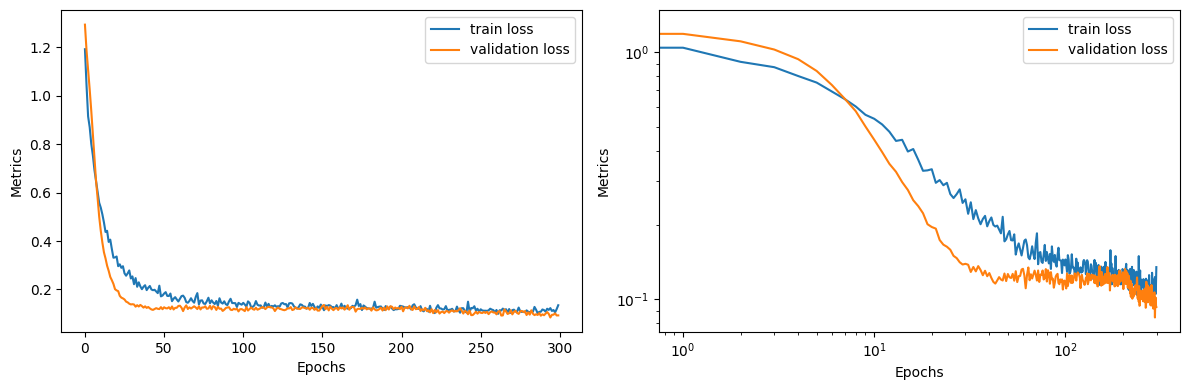

In [8]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [11]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(ann_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(ann_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(ann_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

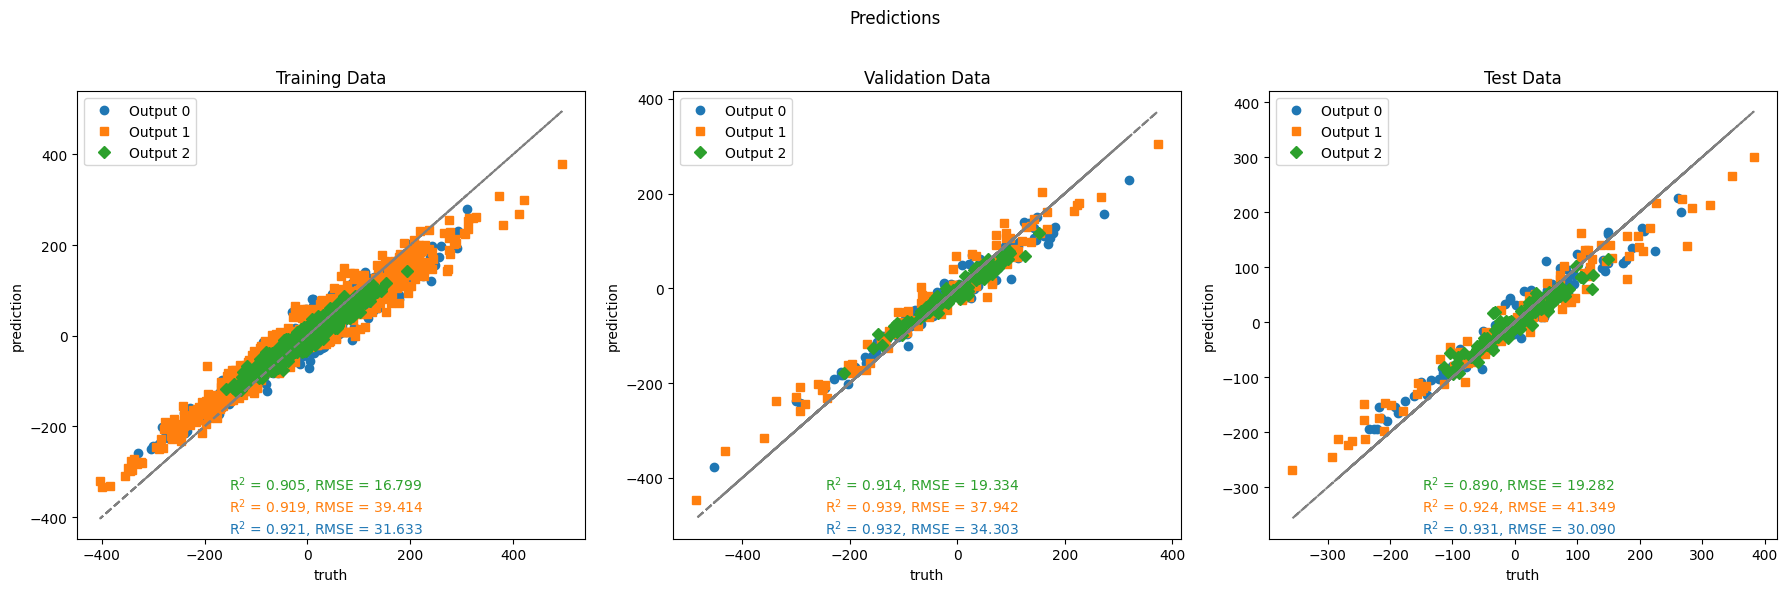

In [14]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

Let's do a quick test to see if we can compute the gradients of the model...

Shape of tfmelt jacobian: (1, 3, 1, 10)


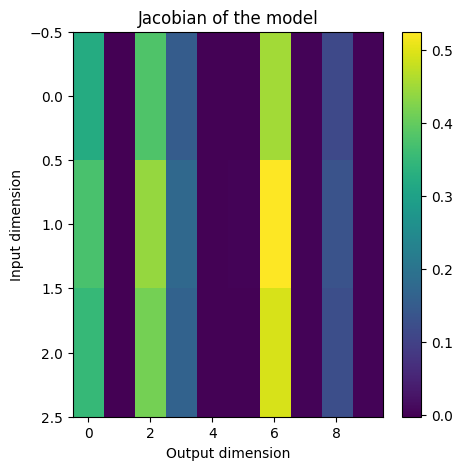

In [20]:
# Compute the tensorflow Jacobian
tfmelt_jacobian = ann_model.compute_jacobian(x_sample)

print(f"Shape of tfmelt jacobian: {tfmelt_jacobian.shape}")

# Plot the Jacobian
plt.figure(figsize=(5, 5))
cb = plt.imshow(tfmelt_jacobian[0, :, 0, :], cmap="viridis", aspect="auto")
plt.colorbar(cb)
plt.title("Jacobian of the model")
plt.xlabel("Output dimension")
plt.ylabel("Input dimension")
plt.show()


In [29]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(ann_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(ann_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(ann_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)


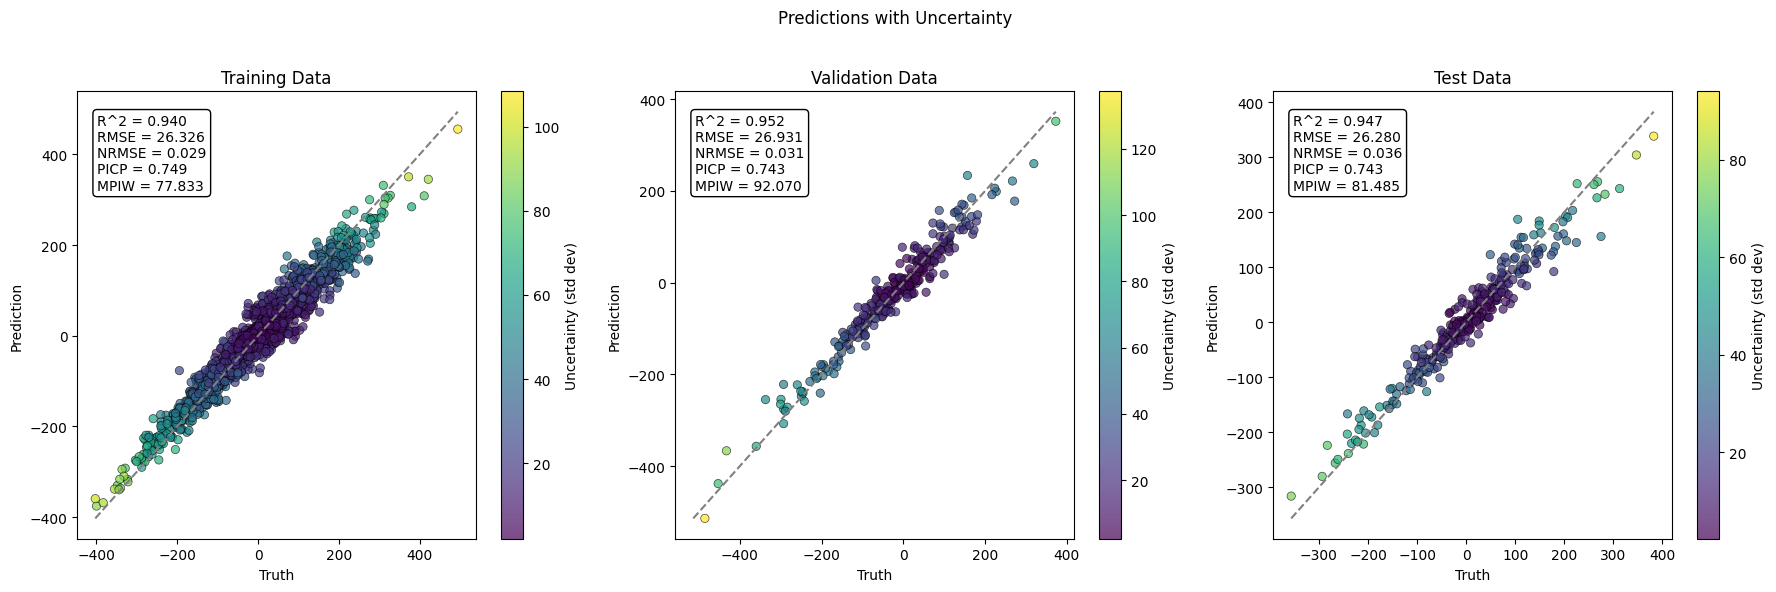

In [30]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
)

## Residual Neural Network (ResNet)
Create and train a ResNet using TF-MELT.

In [21]:
from tfmelt.models import ResidualNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
resnet_model = ResidualNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    layers_per_block=layers_per_block,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    pre_activation=True,
    post_add_activation=False,
    output_activation=output_activation,
)

# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
resnet_model.build(input_shape=(None, n_features))
resnet_model.summary()


Model: "residual_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 input_dropout (Dropout)     multiple                  0         
                                                                 
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 output (Dense)              multiple                  27        
                                           

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:439: UserWarning: Warning: depth (2) is not divisible by layers_per_block (4), so the last block will have 2 layers.
  warnings.warn(


In [22]:
# Train the model
history = resnet_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.6268 - val_loss: 1.7332
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.2822 - val_loss: 1.5206
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 1.1094 - val_loss: 1.4041
Epoch 4/300
25/25 [==============================] - 0s 952us/step - loss: 1.0135 - val_loss: 1.3298
Epoch 5/300
25/25 [==============================] - 0s 885us/step - loss: 0.9658 - val_loss: 1.2712
Epoch 6/300
25/25 [==============================] - 0s 883us/step - loss: 0.9164 - val_loss: 1.2197
Epoch 7/300
25/25 [==============================] - 0s 843us/step - loss: 0.8655 - val_loss: 1.1645
Epoch 8/300
25/25 [==============================] - 0s 787us/step - loss: 0.8154 - val_loss: 1.1056
Epoch 9/300
25/25 [==============================] - 0s 746us/step - loss: 0.7732 - val_loss: 1.0383
Epoch 10/300
25/25 [==============================] - 0s 737us/step - loss: 0.6874 - val_loss: 0.

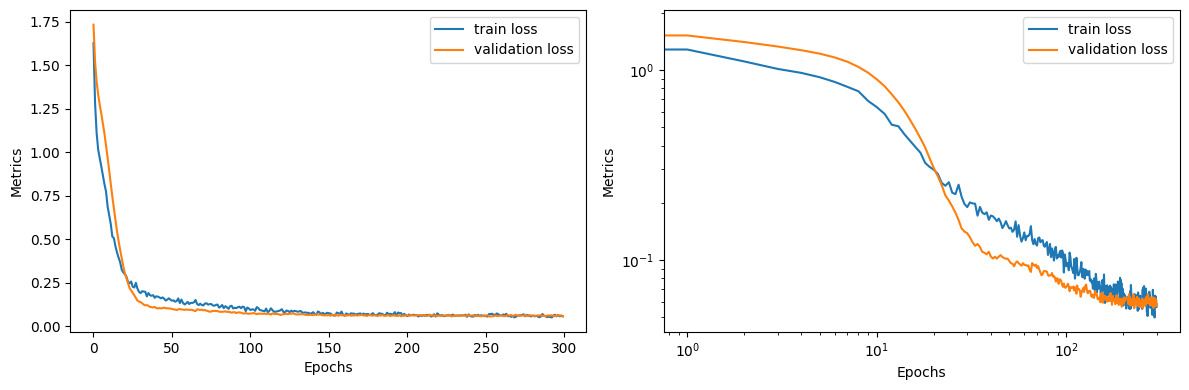

In [23]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [24]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train = make_predictions(resnet_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val = make_predictions(resnet_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test = make_predictions(resnet_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

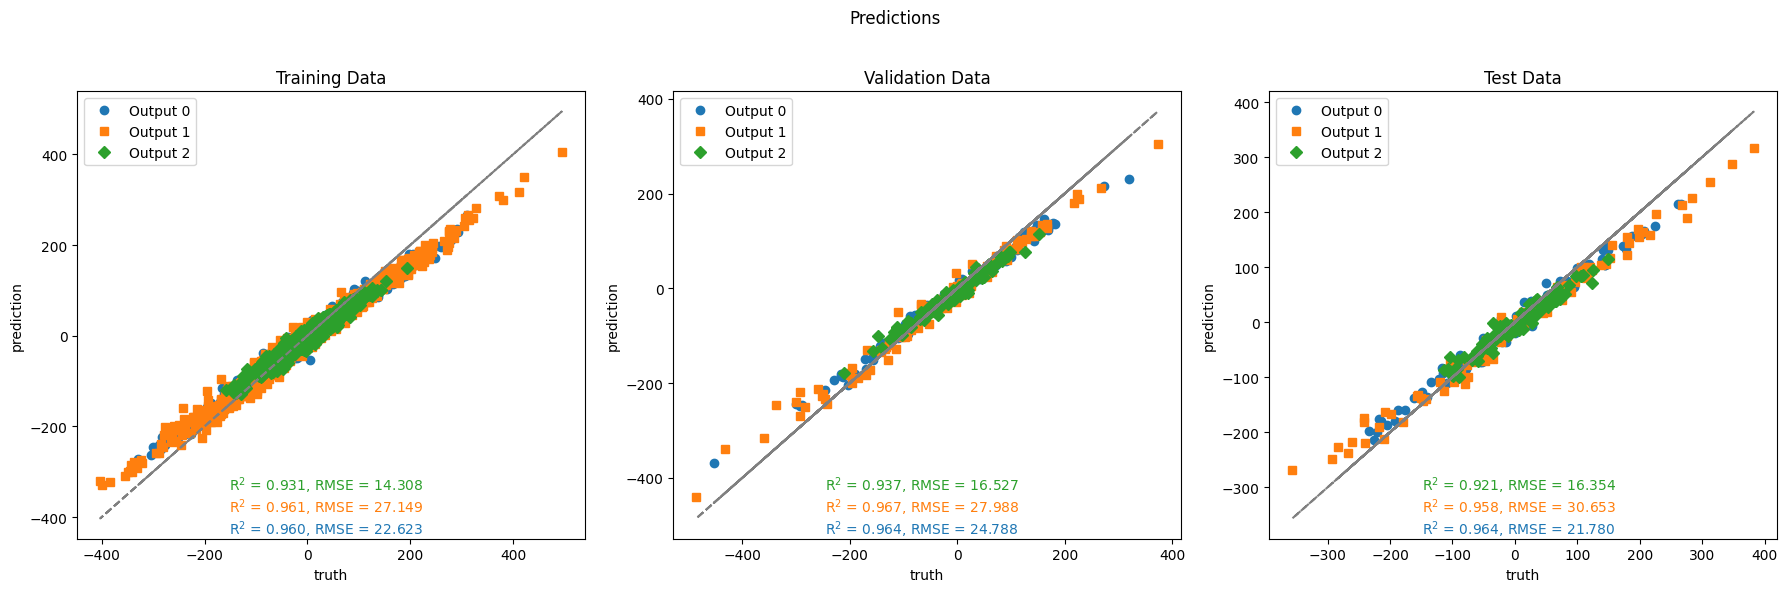

In [25]:
from tfmelt.utils.visualization import plot_predictions

# Plot the predictions
plot_predictions(pred_train, y_train_real, pred_val, y_val_real, pred_test, y_test_real)

In [31]:
from tfmelt.utils.evaluation import ensemble_predictions

# Make ensemble predictions using MC Dropout
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(resnet_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(resnet_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(resnet_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

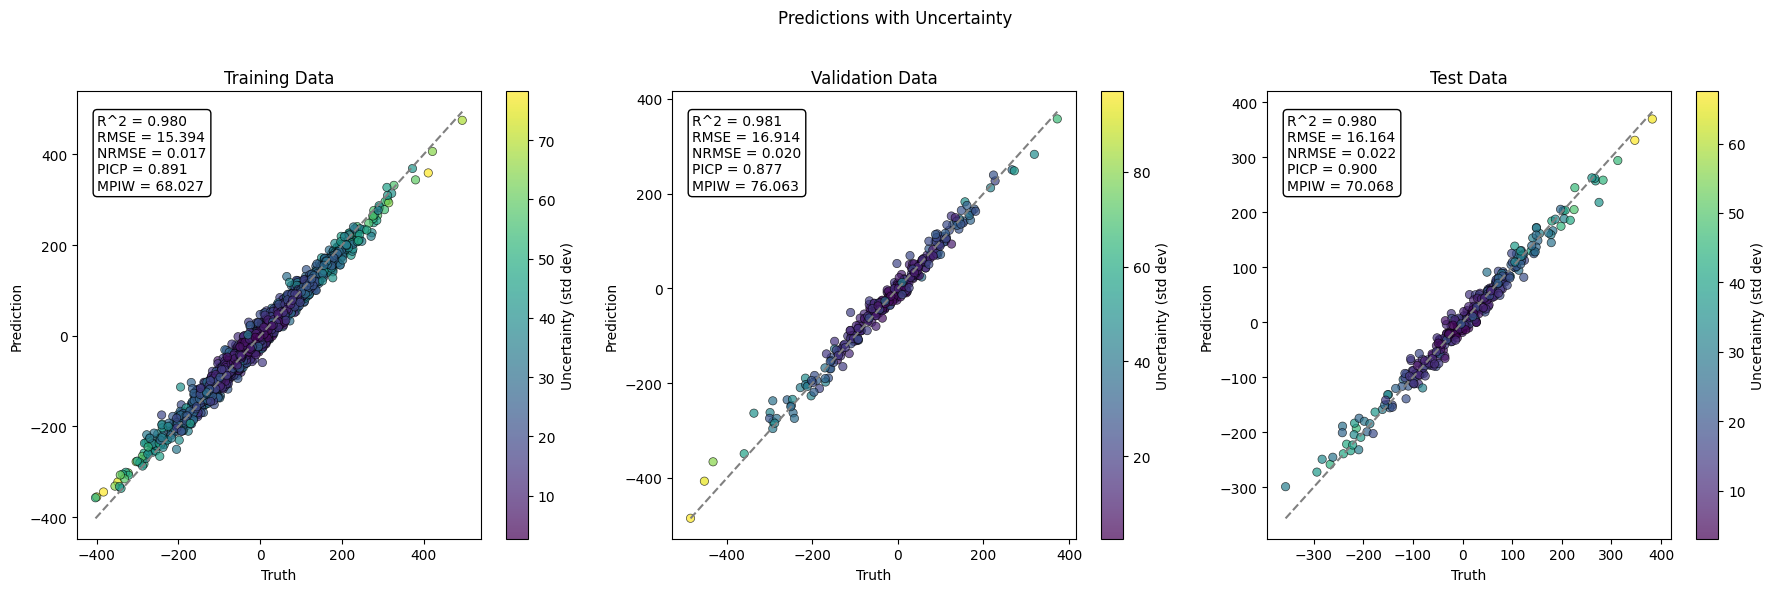

In [32]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot MC Dropout predictions
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
)

# Heteroscedastic ANN

Now enable the direct uncertainty prediction using a modified output layer through num_mixtures parameter

In [9]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
hnn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=1, # Single Gaussian mixture
)

# Compile the model
hnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
hnn_model.build(input_shape=(None, n_features))
hnn_model.summary()

Model: "artificial_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 mean_output (Dense)         multiple                  27        
                                                                 
 log_var_output (Dense)      multiple                  27        
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                                                 
 bulk_1 (Dense)              multiple                  72        
                                       

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:287: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the aleatoric loss function.
  warnings.warn(


In [10]:
# Train the model
history = hnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 3ms/step - loss: 1.0399 - val_loss: 1.2976
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 0.9701 - val_loss: 1.2518
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 0.9254 - val_loss: 1.2084
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 0.8858 - val_loss: 1.1526
Epoch 5/300
25/25 [==============================] - 0s 876us/step - loss: 0.8399 - val_loss: 1.0780
Epoch 6/300
25/25 [==============================] - 0s 886us/step - loss: 0.7815 - val_loss: 0.9586
Epoch 7/300
25/25 [==============================] - 0s 925us/step - loss: 0.6990 - val_loss: 0.7932
Epoch 8/300
25/25 [==============================] - 0s 880us/step - loss: 0.5821 - val_loss: 0.5889
Epoch 9/300
25/25 [==============================] - 0s 909us/step - loss: 0.4307 - val_loss: 0.3639
Epoch 10/300
25/25 [==============================] - 0s 943us/step - loss: 0.2536 - val_loss: 0.13

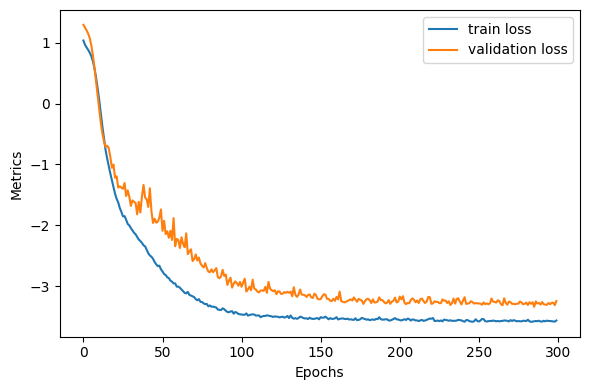

In [11]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [12]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(hnn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(hnn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(hnn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

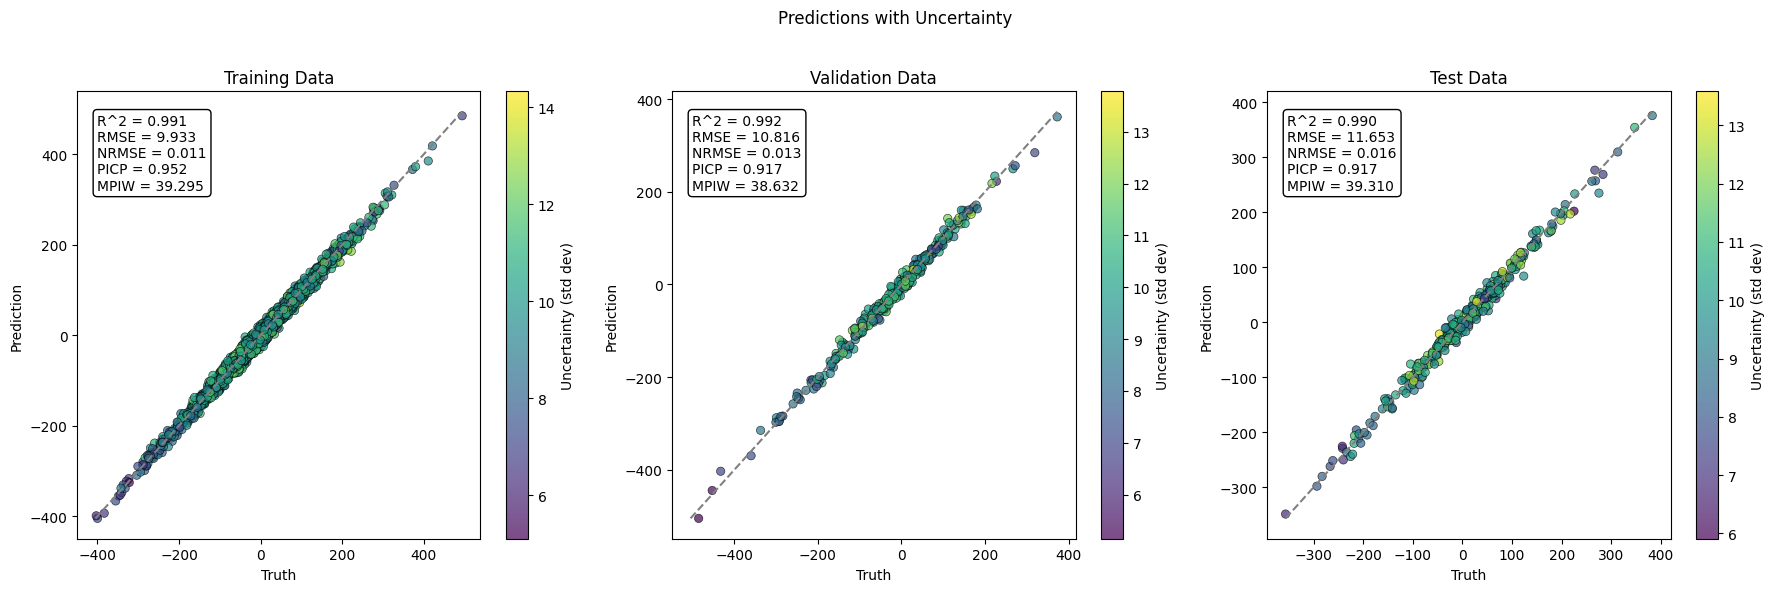

In [13]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
)


# Mixture Density Network
Now increase the number of mixture models for a true MDN

In [19]:
from tfmelt.models import ArtificialNeuralNetwork
from tensorflow.keras.optimizers import Adam

# Create the model
mdn_model = ArtificialNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=0.0, # Remove input dropout
    dropout=0.0, # Remove dropout
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_mixtures=5, # 5 Gaussian mixtures
)

# Compile the model
mdn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
mdn_model.build(input_shape=(None, n_features))
mdn_model.summary()

Model: "artificial_neural_network_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 mix_coeffs (Dense)          multiple                  45        
                                                                 
 mean_output (Dense)         multiple                  135       
                                                                 
 log_var_output (Dense)      multiple                  135       
                                                                 
 bulk_0 (Dense)              multiple                  72        
                                       

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:293: UserWarning: Loss function is overridden when using mixture density networks. Using the mixture density loss function.
  warnings.warn(


In [20]:
# Train the model
history = mdn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 0s 4ms/step - loss: 3.2237 - val_loss: 3.3639
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 3.2053 - val_loss: 3.3336
Epoch 3/300
25/25 [==============================] - 0s 1ms/step - loss: 3.1806 - val_loss: 3.2812
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 3.1405 - val_loss: 3.2035
Epoch 5/300
25/25 [==============================] - 0s 845us/step - loss: 3.0781 - val_loss: 3.1060
Epoch 6/300
25/25 [==============================] - 0s 803us/step - loss: 2.9857 - val_loss: 2.9760
Epoch 7/300
25/25 [==============================] - 0s 846us/step - loss: 2.8562 - val_loss: 2.8278
Epoch 8/300
25/25 [==============================] - 0s 845us/step - loss: 2.7152 - val_loss: 2.7062
Epoch 9/300
25/25 [==============================] - 0s 865us/step - loss: 2.5937 - val_loss: 2.5978
Epoch 10/300
25/25 [==============================] - 0s 811us/step - loss: 2.4983 - val_loss: 2.52

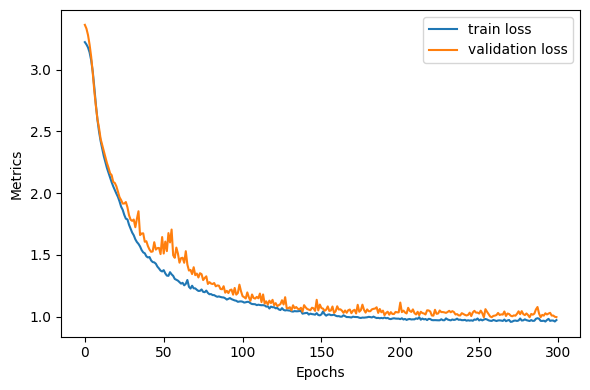

In [21]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [22]:
from tfmelt.utils.evaluation import make_predictions

# Evaluate the model performance on train, validation, and test data
pred_train, pred_train_std = make_predictions(mdn_model, x_train, y_normalizer=y_normalizer, unnormalize=True)
pred_val, pred_val_std = make_predictions(mdn_model, x_val, y_normalizer=y_normalizer, unnormalize=True)
pred_test, pred_test_std = make_predictions(mdn_model, x_test, y_normalizer=y_normalizer, unnormalize=True)

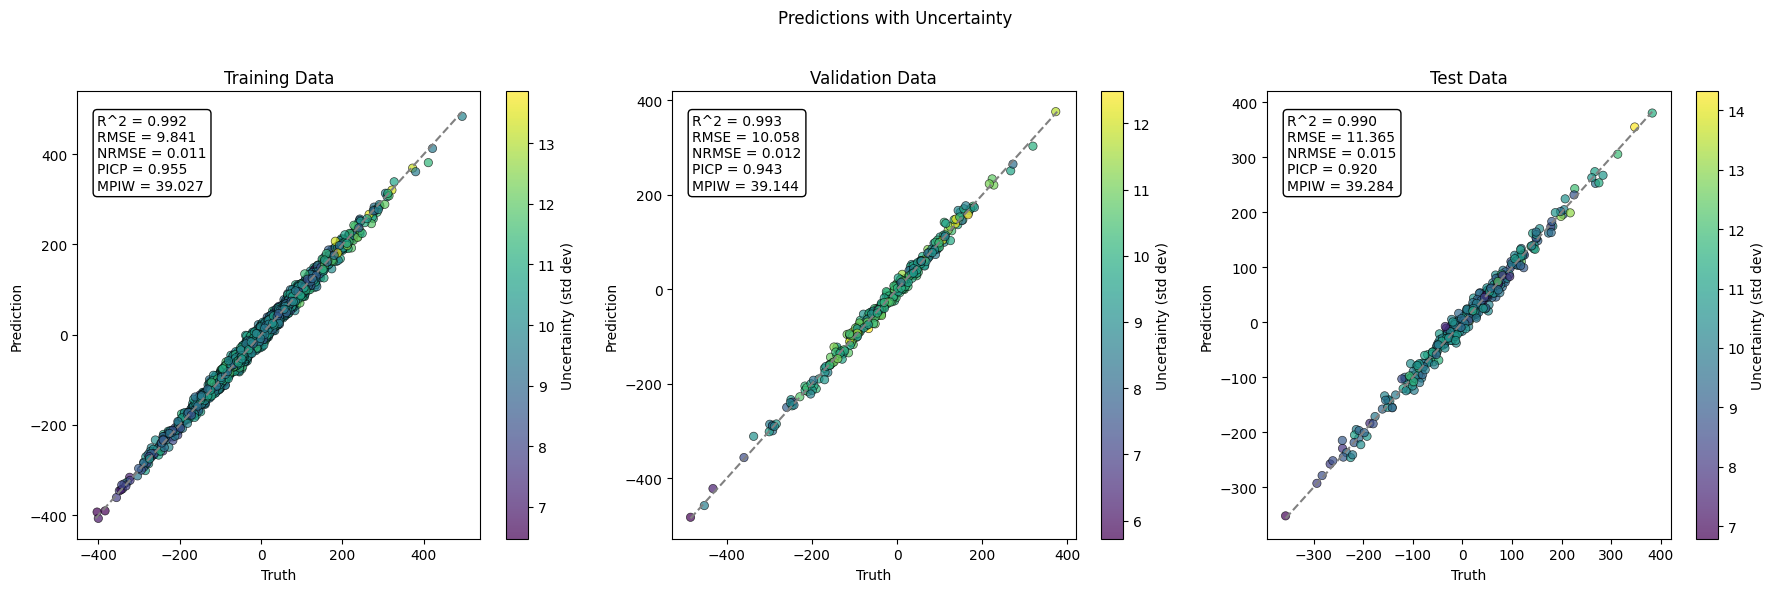

In [23]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions
plot_predictions_with_uncertainty(
    pred_train, pred_train_std, y_train_real,
    pred_val, pred_val_std, y_val_real,
    pred_test, pred_test_std, y_test_real,
    metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
)

## Bayesian Neural Network (BNN)
Create and train a BNN using TF-MELT. We can specify the number of bayesian layers desired to increase complexity.

#### Epistemic Uncertainty Predictions
We will turn off the aleatoric output layer and instead train an epistemic BNN model (of varying number of layers). Predictions will be made using Monte Carlo methods.

In [24]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
width = 8
depth = 3
num_bayesian_layers = 3
do_aleatoric = False

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    num_bayesian_layers=num_bayesian_layers,
    do_aleatoric=do_aleatoric,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()


Model: "bayesian_neural_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input2bulk (Dense)          multiple                  88        
                                                                 
 input2bulk_act (Activation  multiple                  0         
 )                                                               
                                                                 
 bayesian_0 (DenseFlipout)   multiple                  136       
                                                                 
 bayesian_1 (DenseFlipout)   multiple                  136       
                                                                 
 bayesian_2 (DenseFlipout)   multiple                  136       
                                                                 
 bulk_act_0 (Activation)     multiple                  0         
                                           

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [25]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/300
25/25 [==============================] - 1s 9ms/step - loss: 1.6330 - val_loss: 2.0272
Epoch 2/300
25/25 [==============================] - 0s 1ms/step - loss: 1.6236 - val_loss: 2.0185
Epoch 3/300
25/25 [==============================] - 0s 2ms/step - loss: 1.6068 - val_loss: 1.9977
Epoch 4/300
25/25 [==============================] - 0s 1ms/step - loss: 1.5619 - val_loss: 1.9379
Epoch 5/300
25/25 [==============================] - 0s 1ms/step - loss: 1.4533 - val_loss: 1.7665
Epoch 6/300
25/25 [==============================] - 0s 1ms/step - loss: 1.2750 - val_loss: 1.6119
Epoch 7/300
25/25 [==============================] - 0s 1ms/step - loss: 1.1717 - val_loss: 1.5378
Epoch 8/300
25/25 [==============================] - 0s 1ms/step - loss: 1.1209 - val_loss: 1.5036
Epoch 9/300
25/25 [==============================] - 0s 1ms/step - loss: 1.0895 - val_loss: 1.4590
Epoch 10/300
25/25 [==============================] - 0s 1ms/step - loss: 1.0646 - val_loss: 1.4432
Epoch 11/

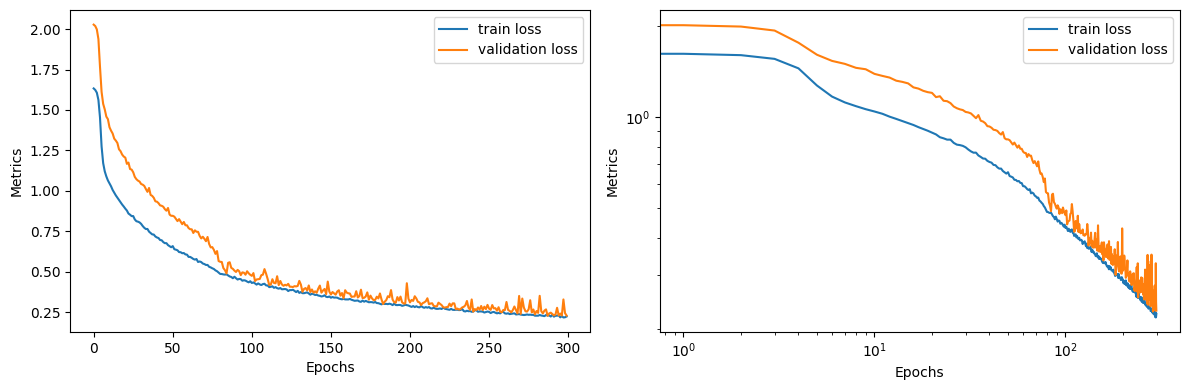

In [27]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=True)

In [31]:
from tfmelt.utils.evaluation import ensemble_predictions

# Evaluate the model performance on train, validation, and test data
n_iter = 100
pred_train_mean, pred_train_std = ensemble_predictions(bnn_model, x_train, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_val_mean, pred_val_std = ensemble_predictions(bnn_model, x_val, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)
pred_test_mean, pred_test_std = ensemble_predictions(bnn_model, x_test, y_normalizer, unnormalize=True, n_iter=n_iter, training=True)

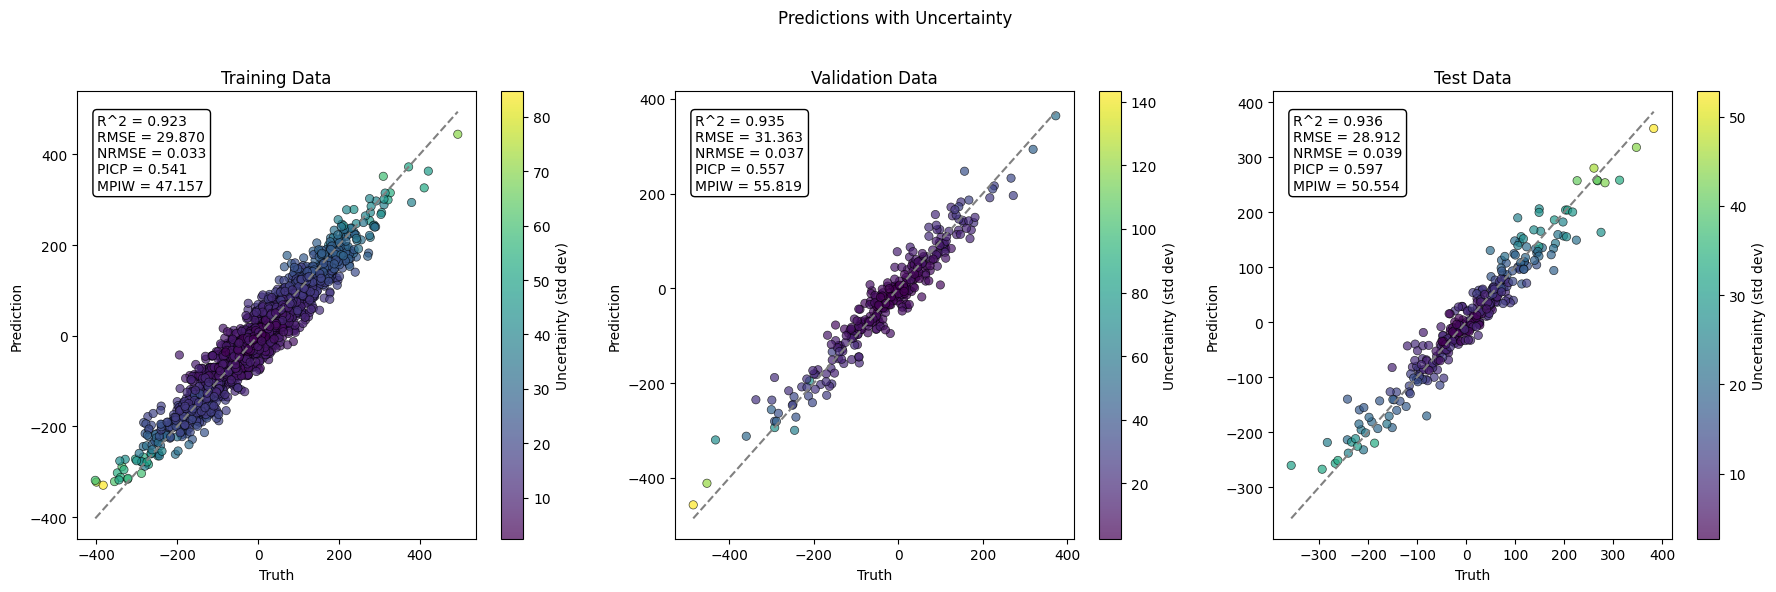

In [32]:
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Plot the predictions from the ensemble
plot_predictions_with_uncertainty(
    pred_train_mean, pred_train_std, y_train_real,
    pred_val_mean, pred_val_std, y_val_real,
    pred_test_mean, pred_test_std, y_test_real,
    metrics_to_display=["R^2", "RMSE", "NRMSE", "PICP", "MPIW"]
)

#### Aleatoric Uncertainty Predictions
Now examine aleatoric uncertainty predictions as well as combined predictions if `num_bayesian_layers` is greater than 1.

In [33]:
from tfmelt.models import BayesianNeuralNetwork
from tensorflow.keras.optimizers import Adam

# BNN specific hyperparameters
dropout = 0.0
input_dropout = 0.0
width = 8
depth = 3
num_bayesian_layers = 3
do_aleatoric = True
batch_norm = True
use_batch_renorm = True
n_epochs = 200
l1_reg = 0
l2_reg = 0

# Create the model
bnn_model = BayesianNeuralNetwork(
    num_outputs=n_targets,
    width=width,
    depth=depth,
    act_fun=act_fun,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    input_dropout=input_dropout,
    dropout=dropout,
    batch_norm=batch_norm,
    output_activation=output_activation,
    num_points=x_train.shape[0],
    num_bayesian_layers=num_bayesian_layers,
    do_aleatoric=do_aleatoric,
    use_batch_renorm=use_batch_renorm,
)

# Compile the model
bnn_model.compile(
    optimizer=Adam(learning_rate=learn_rate),
    loss=loss,
)

# Build model and print summary
bnn_model.build(input_shape=(None, n_features))
bnn_model.summary()

/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tfmelt/models.py:747: UserWarning: Loss function is overridden when using aleatoric uncertainty. Using the negative log likelihood loss function.
  warnings.warn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/nwimer/miniconda3/envs/tf-melt/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "bayesian_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_norm_0 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_1 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_2 (BatchNormali  multiple                  56        
 zation)                                                         
                                                                 
 batch_norm_3 (BatchNormali  multiple                  0 (unused)
 zation)                                                         
                                                                 
 input2bulk (Dense)          multiple    

In [34]:
# Train the model
history = bnn_model.fit(
    x_train, y_train, 
    validation_data=(x_val, y_val), 
    epochs=n_epochs, 
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/200
25/25 [==============================] - 1s 9ms/step - loss: 2.0903 - val_loss: 2.4625
Epoch 2/200
25/25 [==============================] - 0s 2ms/step - loss: 2.0452 - val_loss: 2.4169
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 1.9877 - val_loss: 2.3116
Epoch 4/200
25/25 [==============================] - 0s 2ms/step - loss: 1.9140 - val_loss: 2.0825
Epoch 5/200
25/25 [==============================] - 0s 1ms/step - loss: 1.7487 - val_loss: 1.7343
Epoch 6/200
25/25 [==============================] - 0s 1ms/step - loss: 1.5019 - val_loss: 1.4441
Epoch 7/200
25/25 [==============================] - 0s 1ms/step - loss: 1.3615 - val_loss: 1.3439
Epoch 8/200
25/25 [==============================] - 0s 1ms/step - loss: 1.3280 - val_loss: 1.3021
Epoch 9/200
25/25 [==============================] - 0s 1ms/step - loss: 1.2763 - val_loss: 1.3291
Epoch 10/200
25/25 [==============================] - 0s 1ms/step - loss: 1.2488 - val_loss: 1.2557
Epoch 11/

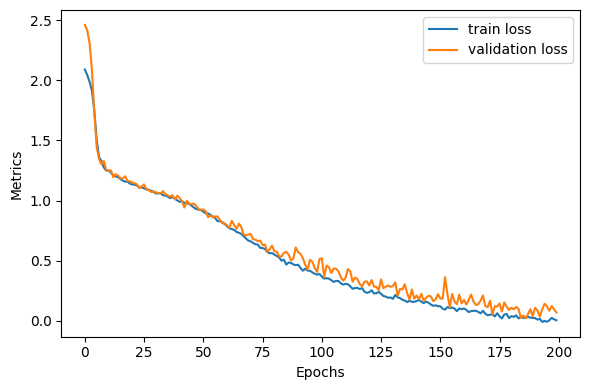

In [36]:
from tfmelt.utils.visualization import plot_history

# Plot the loss function over time
plot_history(history, metrics=["loss"], plot_log=False)

In [37]:
# Evaluate the model performance with Monte Carlo ensemble predictions for Aleatoric and Epistemic Uncertainty
import numpy as np
import tensorflow_probability as tfp

num_preds = 100
pred_norm_train = np.stack([bnn_model(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([bnn_model(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([bnn_model(x_test, training=False) for _ in range(num_preds)], axis=0)

# If we are using aleatoric uncertainty, we have to unscale the distribution parameters
if do_aleatoric:
    pred_train = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_train])
    pred_val = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_val])
    pred_test = np.stack([tfp.distributions.Normal(loc=y_normalizer.inverse_transform(y.mean()).astype(np.float32), scale=np.float32(y_normalizer.scale_) * y.stddev()) for y in pred_norm_test])

    pred_mean_train = np.stack([y.mean().numpy() for y in pred_train]).mean(axis=0)
    pred_eu_train = np.stack([y.mean().numpy() for y in pred_train]).std(axis=0)
    pred_au_train = np.stack([y.stddev().numpy() for y in pred_train]).mean(axis=0)

    pred_mean_val = np.stack([y.mean().numpy() for y in pred_val]).mean(axis=0)
    pred_eu_val = np.stack([y.mean().numpy() for y in pred_val]).std(axis=0)
    pred_au_val = np.stack([y.stddev().numpy() for y in pred_val]).mean(axis=0)

    pred_mean_test = np.stack([y.mean().numpy() for y in pred_test]).mean(axis=0)
    pred_eu_test = np.stack([y.mean().numpy() for y in pred_test]).std(axis=0)
    pred_au_test = np.stack([y.stddev().numpy() for y in pred_test]).mean(axis=0)
    
# If we are not using aleatoric uncertainty, we can unscale the predictions directly
else:
    pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
    pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
    pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

    # Compute the mean and standard deviation of the predictions
    pred_mean_train = np.mean(pred_train, axis=0)
    pred_eu_train = np.std(pred_train, axis=0)
    pred_au_train = np.zeros(pred_mean_train.shape)

    pred_mean_val = np.mean(pred_val, axis=0)
    pred_eu_val = np.std(pred_val, axis=0)
    pred_au_val = np.zeros(pred_mean_val.shape)

    pred_mean_test = np.mean(pred_test, axis=0)
    pred_eu_test = np.std(pred_test, axis=0)
    pred_au_test = np.zeros(pred_mean_test.shape)



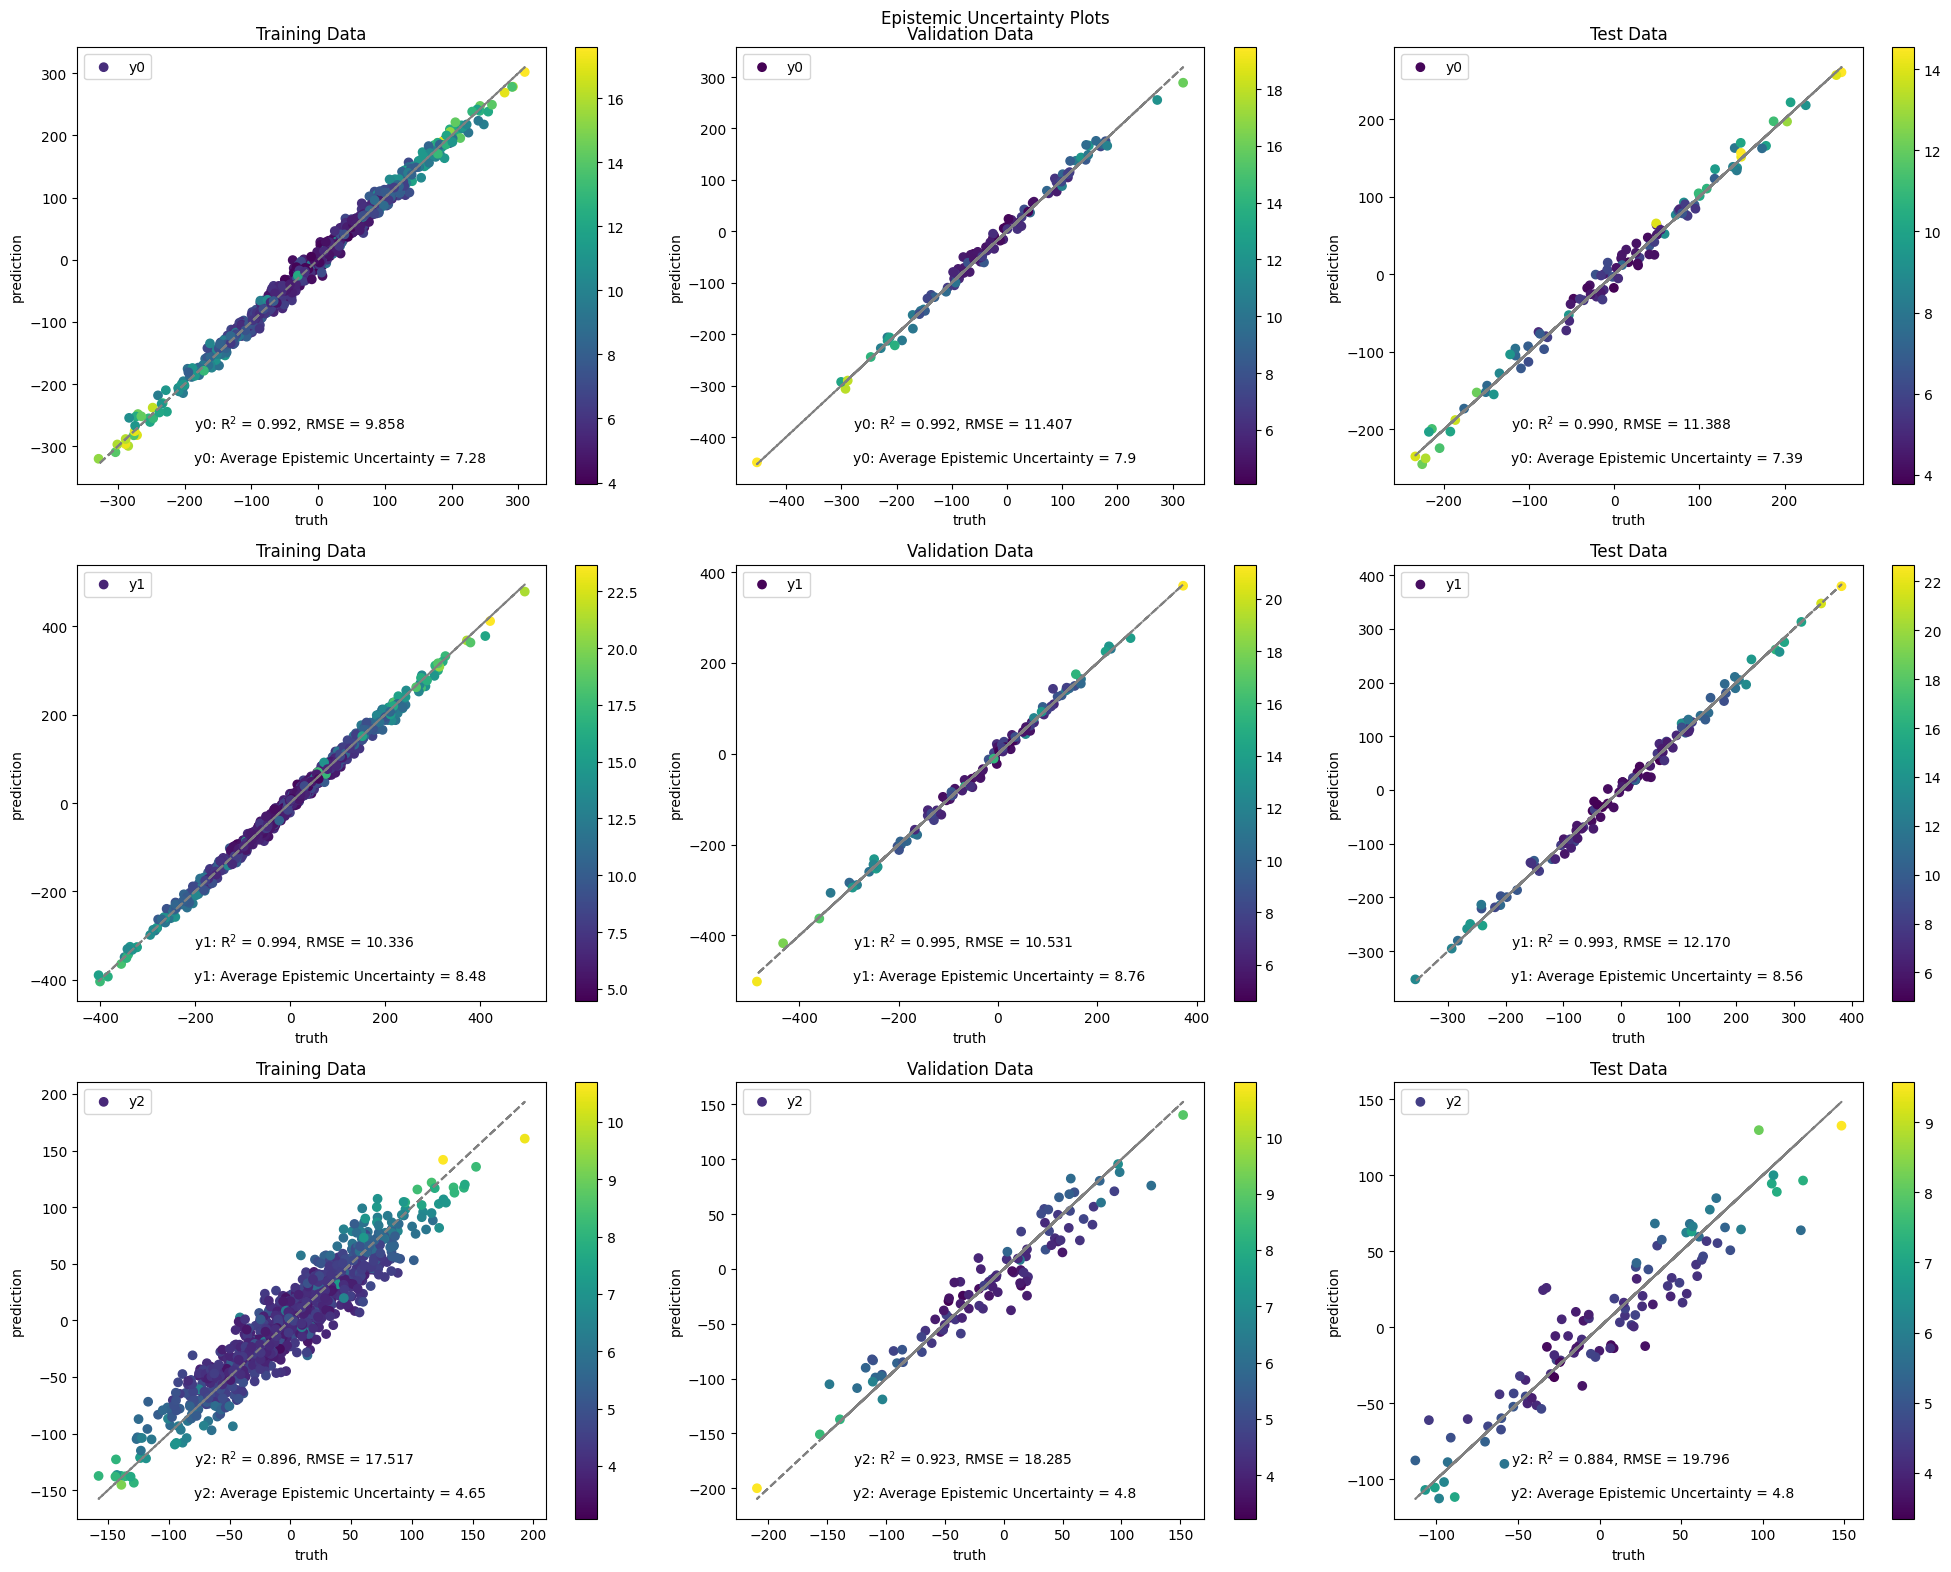

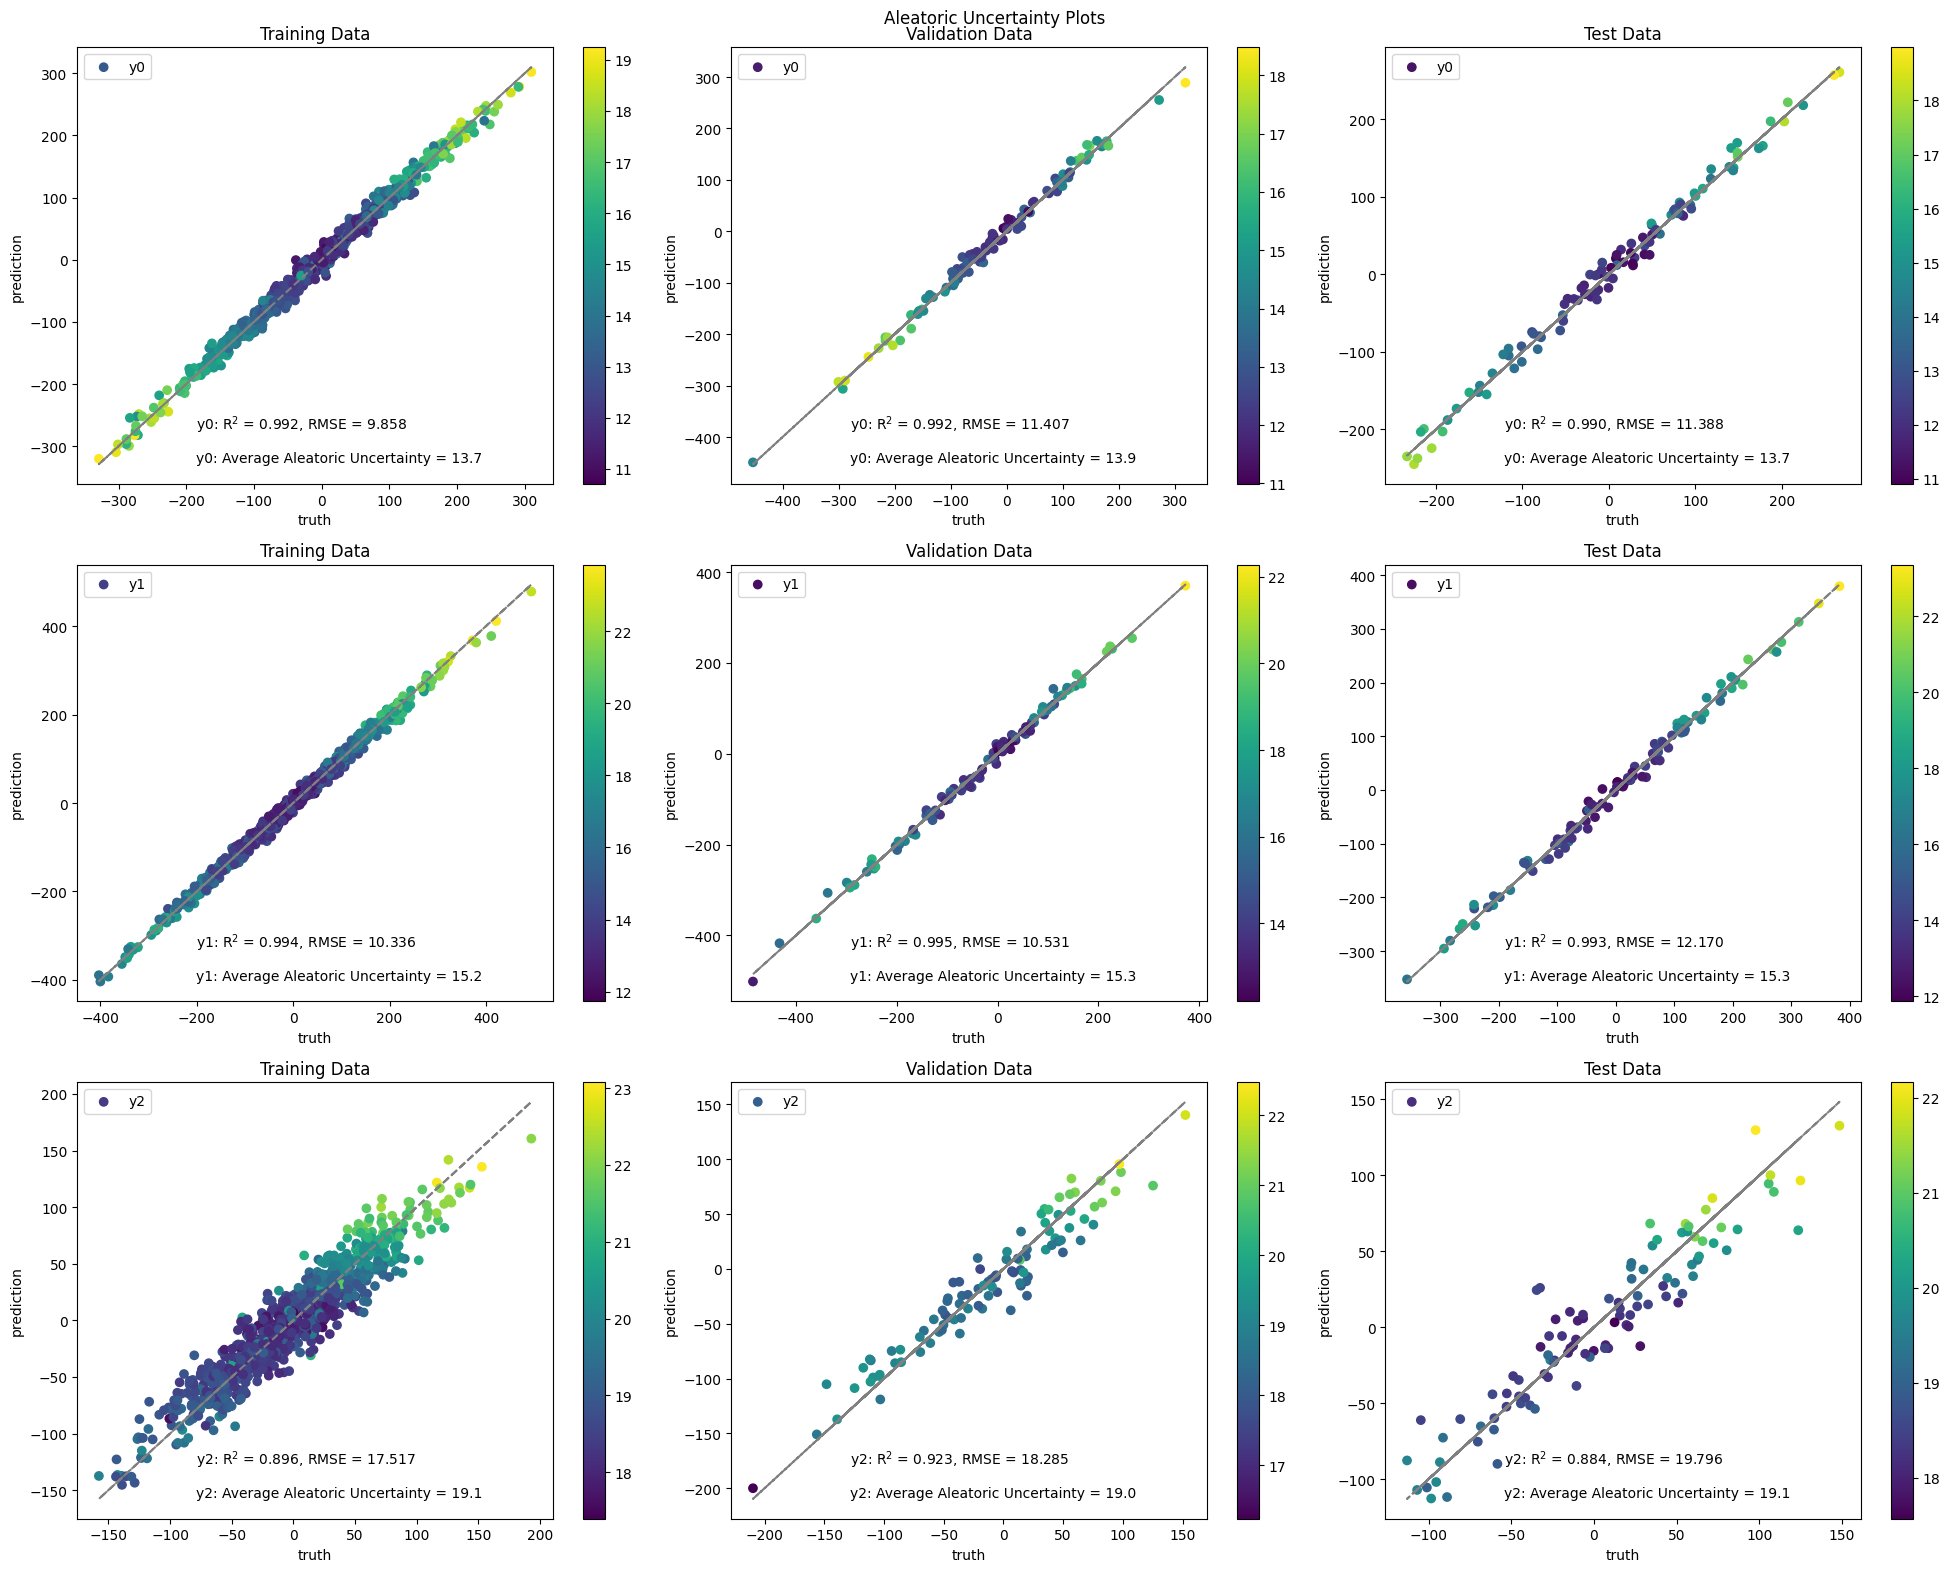

In [38]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Epistemic Uncertainty = {np.mean(pred_eu_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_train[:, i]):0.3}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    ax2.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_val[:, i]):0.3}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.05, s=rf"y{i}: Average Aleatoric Uncertainty = {np.mean(pred_au_test[:, i]):0.3}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()